    Build the following network:
    That takes a CIFAR10 image (32x32x3)

    Add 3 Convolutions to arrive at AxAx48 dimensions (e.g. 32x32x3 |    3x3x3x16 >> 3x3x16x32 >> 3x3x32x48)

    Apply GAP and get 1x1x48, call this X

    Create a block called ULTIMUS that:

    Creates 3 FC layers called K, Q and V such that:

    X*K = 48*48x8 > 8

    X*Q = 48*48x8 > 8 

    X*V = 48*48x8 > 8 

    then create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
    then Z = V*AM = 8*8 > 8
    then another FC layer called Out that:
    Z*Out = 8*8x48 > 48

    Repeat this Ultimus block 4 times

    Then add final FC layer that converts 48 to 10 and sends it to the loss function.

    Model would look like this 

    C>C>C>U>U>U>U>FFC>Loss

    Train the model for 24 epochs using the OCP that I wrote in class. Use ADAM as an optimizer. **

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np 
from models.model import *
from utils import *
from main import *
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Loading test and train datasets & dataloader**

In [2]:
# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

trainset = cifar10.data(train_flag=True)

testset =  cifar10.data(train_flag=False)
# load Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Load Test dataloader
testloader = cifar10.loader(train_flag=False)

# Get all the classes
classes = cifar10.classes


CUDA availability ? True
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Import Model

In [3]:
# Loading ResNet18 Model
model = Model()
# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# Sending network to device
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 32, 32]           4,640
            Conv2d-3           [-1, 48, 32, 32]          13,872
 AdaptiveAvgPool2d-4             [-1, 48, 1, 1]               0
            Linear-5                    [-1, 8]             392
            Linear-6                    [-1, 8]             392
            Linear-7                    [-1, 8]             392
            Linear-8                   [-1, 48]             432
      UltimusBlock-9                   [-1, 48]               0
           Linear-10                    [-1, 8]             392
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                   [-1, 48]             432
     UltimusBlock-14              

#Define Optimizer, LossCriterion and draw the plot

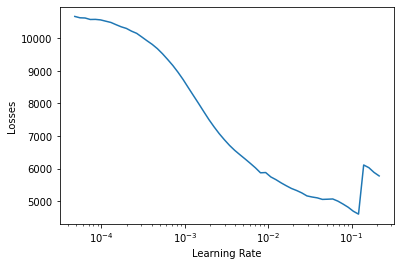

In [6]:
from clr import *
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
clr = CLR(optimizer, len(trainloader),1e-5,10)
calculate_lr(model , optimizer, trainloader , criterion, clr, device)
clr.plot()

# Calling the Model with 24 Epochs

In [7]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24
bs = 512
torch.autograd.set_detect_anomaly(True)
model =  Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
l1reg = False
# calculate the total number of steps
total_steps = len(trainloader) * 24

# calculate the step size for the first 5 epochs
step_size_up = len(trainloader) * 5
scheduler = OneCycleLR(optimizer, max_lr=0.077, total_steps=total_steps, pct_start=step_size_up/total_steps, anneal_strategy='cos', cycle_momentum=False)

train_loss, test_loss, train_acc, test_acc , test_pred, target_pred, target_data = main(EPOCHS, model, device, trainloader, testloader, optimizer, criterion,scheduler,l1reg)


Epoch 0 : 
Train set: Average loss: 2.3020, Accuracy: 13.16

Test set: Average loss: 0.005, Accuracy: 10.00

Epoch 1 : 
Train set: Average loss: 2.3049, Accuracy: 10.63

Test set: Average loss: 0.005, Accuracy: 10.00

Epoch 2 : 
Train set: Average loss: 2.3163, Accuracy: 9.95

Test set: Average loss: 0.005, Accuracy: 10.00

Epoch 3 : 
Train set: Average loss: 56678.2969, Accuracy: 10.07

Test set: Average loss: 368.239, Accuracy: 10.00

Epoch 4 : 
Train set: Average loss: 65302.3750, Accuracy: 10.02

Test set: Average loss: 884.942, Accuracy: 10.00

Epoch 5 : 
Train set: Average loss: 1764.8209, Accuracy: 9.93

Test set: Average loss: 17.722, Accuracy: 10.00

Epoch 6 : 
Train set: Average loss: 23000.9414, Accuracy: 10.06

Test set: Average loss: 12.444, Accuracy: 10.00

Epoch 7 : 
Train set: Average loss: 538.4319, Accuracy: 9.99

Test set: Average loss: 1.217, Accuracy: 10.00

Epoch 8 : 
Train set: Average loss: 64.2081, Accuracy: 9.79

Test set: Average loss: 0.209, Accuracy: 10.00

 Training and Validation loss chart

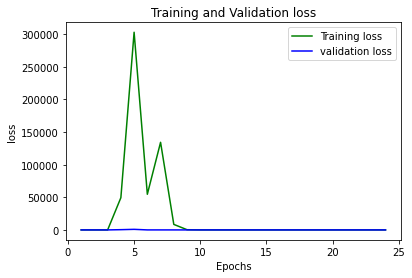

In [8]:
plot_train_vs_test_loss(EPOCHS, train_loss, test_loss)